In [2]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K


num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.3
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

Using TensorFlow backend.


In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

In [4]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

In [5]:
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [6]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

W1025 16:24:28.391051 12036 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1025 16:24:28.497096 12036 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1025 16:24:28.572136 12036 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1025 16:24:28.593125 12036 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1025 16:24:28.604119 12036 deprecation.py:506

In [7]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

W1025 16:24:28.803907 12036 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1025 16:24:28.952821 12036 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1025 16:24:29.474341 12036 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 8s 76us/step - loss: 0.0953 - accuracy: 0.8866 - val_loss: 0.0438 - val_accuracy: 0.9558
Epoch 2/20
108400/108400 [==============================] - 9s 79us/step - loss: 0.0401 - accuracy: 0.9603 - val_loss: 0.0285 - val_accuracy: 0.9701
Epoch 3/20
108400/108400 [==============================] - 7s 69us/step - loss: 0.0272 - accuracy: 0.9723 - val_loss: 0.0255 - val_accuracy: 0.9718
Epoch 4/20
108400/108400 [==============================] - 8s 69us/step - loss: 0.0218 - accuracy: 0.9772 - val_loss: 0.0246 - val_accuracy: 0.9690
Epoch 5/20
108400/108400 [==============================] - 7s 62us/step - loss: 0.0181 - accuracy: 0.9805 - val_loss: 0.0243 - val_accuracy: 0.9713
Epoch 6/20
108400/108400 [==============================] - 7s 68us/step - loss: 0.0162 - accuracy: 0.9827 - val_loss: 0.0226 - val_accuracy: 0.9719
Epoch 7/20
108400/108400 [=============================

In [8]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.41%
* Accuracy on test set: 96.60%


In [9]:
y_pred

array([[0.00771919],
       [1.3799137 ],
       [0.00275083],
       ...,
       [0.925142  ],
       [0.01721895],
       [1.189351  ]], dtype=float32)

In [11]:
import matplotlib.pyplot as plt

def show_image(img):
    plt.imshow(img, cmap="gray")
    plt.show()

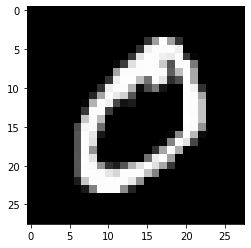

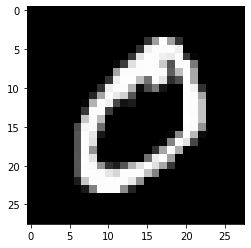

(None, None, 1)

In [15]:
show_image(tr_pairs[0][0]), show_image(tr_pairs[1][0]), tr_y[0]